## **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score


## **Data Wrangling**

### Gathering Data
load dan read data

In [4]:
# membaca data
data = pd.read_csv('/content/data_clean.csv')
data.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
# mengambil data station aotizhongxin
data_Aotizhongxin = data[data['station'] == 'Aotizhongxin']
data_Aotizhongxin.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


### Data Assessing
mengecek data duplicate, null, statistik, dan informasi data

In [6]:
# mengecek informasi dataset
data_Aotizhongxin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 0 to 35063
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     35064 non-null  int64  
 1   month    35064 non-null  int64  
 2   day      35064 non-null  int64  
 3   hour     35064 non-null  int64  
 4   PM2.5    35064 non-null  float64
 5   PM10     35064 non-null  float64
 6   SO2      35064 non-null  float64
 7   NO2      35064 non-null  float64
 8   CO       35064 non-null  float64
 9   O3       35064 non-null  float64
 10  TEMP     35064 non-null  float64
 11  PRES     35064 non-null  float64
 12  DEWP     35064 non-null  float64
 13  RAIN     35064 non-null  float64
 14  wd       35064 non-null  object 
 15  WSPM     35064 non-null  float64
 16  station  35064 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 4.8+ MB


In [7]:
# mengecek data null
data_Aotizhongxin.isna().sum()

,0
year,0
month,0
day,0
hour,0
PM2.5,0
PM10,0
SO2,0
NO2,0
CO,0
O3,0


In [8]:
# mengecek data duplicate
data_Aotizhongxin.duplicated().sum()

0

In [9]:
# mengetahui data statistik dataset
data_Aotizhongxin.describe()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,2014.662560,6.522930,15.729637,11.500000,82.773611,110.060391,17.375901,59.305833,1262.945145,56.353358,13.584607,1011.846920,3.123062,0.067421,1.708496
std,1.177213,3.448752,8.800218,6.922285,81.045038,94.243001,22.516658,36.570739,1190.100376,56.478782,11.395845,10.401079,13.684991,0.909796,1.203831
min,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-16.800000,985.900000,-35.300000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.750000,23.000000,39.000000,3.000000,31.000000,500.000000,9.000000,3.100000,1003.300000,-8.100000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,11.500000,61.000000,89.000000,9.000000,55.000000,900.000000,46.000000,14.500000,1011.400000,3.800000,0.000000,1.400000
75%,2016.000000,10.000000,23.000000,17.250000,112.000000,153.000000,21.000000,81.000000,1500.000000,80.000000,23.300000,1020.100000,15.600000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.500000,72.500000,11.200000


### Cleaning Data

melakukan pembersihan data

In [10]:
# mengubah kolom tahun, bulan, hari, dan jam mejadi satu kolom datetime
data_Aotizhongxin['datetime'] = pd.to_datetime(data_Aotizhongxin[['year', 'month', 'day', 'hour']])

<ipython-input-10-ab858a9e1e0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Aotizhongxin['datetime'] = pd.to_datetime(data_Aotizhongxin[['year', 'month', 'day', 'hour']])


In [11]:
# menyisakan data polutan saja
data_Aotizhongxin = data_Aotizhongxin.drop(columns=['year', 'month', 'day', 'hour', 'station', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'], axis=1)
data_Aotizhongxin.head()

,PM2.5,PM10,SO2,NO2,CO,O3,datetime
0,4.0,4.0,4.0,7.0,300.0,77.0,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,2013-03-01 04:00:00


In [12]:
# mengubah datetime menjadi index
data_index = data_Aotizhongxin.set_index(['datetime'])
data_index.head()

,PM2.5,PM10,SO2,NO2,CO,O3
datetime,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0


## **Split Data**

In [13]:
# menyimpan data value dan index untuk dilakukan split data
data_values = data_index.values
data_index_values = data_index.index

# membagi data menjadi 80% train, 10% validation, dan 10% test
train_size = int(len(data_values) * 0.8)
val_size = int(len(data_values) * 0.1)

# membagi data value
train_data = data_values[:train_size]
val_data = data_values[train_size:train_size + val_size]
test_data = data_values[train_size + val_size:]

# membagi data index
train_index = data_index_values[:train_size]
val_index = data_index_values[train_size:train_size + val_size]
test_index = data_index_values[train_size + val_size:]

In [14]:
print(f"Train Data: {len(train_data)} sampel")
print(f"Validation Data: {len(val_data)} sampel")
print(f"Test Data: {len(test_data)} sampel")

Train Data: 28051 sampel
Validation Data: 3506 sampel
Test Data: 3507 sampel


## **Data Transformation**

### Membuat fitur baru dari `wind direction`

In [15]:
# train_data_df = pd.DataFrame(train_data, columns=data_index.columns, index=train_index)
# val_data_df = pd.DataFrame(val_data, columns=data_index.columns, index=val_index)
# test_data_df = pd.DataFrame(test_data, columns=data_index.columns, index=test_index)

In [16]:
# # mapping arah angin ke derajat
# wind_directions = {
#     'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5,
#     'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
#     'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
# }

# # mapping arah angin ke derajat
# train_data_df['Wind_Degrees'] = train_data_df['wd'].map(wind_directions)
# val_data_df['Wind_Degrees'] = val_data_df['wd'].map(wind_directions)
# test_data_df['Wind_Degrees'] = test_data_df['wd'].map(wind_directions)

# # transform ke sin & cos
# train_data_df['Wind_Sin'] = np.sin(np.radians(train_data_df['Wind_Degrees']))
# train_data_df['Wind_Cos'] = np.cos(np.radians(train_data_df['Wind_Degrees']))
# val_data_df['Wind_Sin'] = np.sin(np.radians(val_data_df['Wind_Degrees']))
# val_data_df['Wind_Cos'] = np.cos(np.radians(val_data_df['Wind_Degrees']))
# test_data_df['Wind_Sin'] = np.sin(np.radians(test_data_df['Wind_Degrees']))
# test_data_df['Wind_Cos'] = np.cos(np.radians(test_data_df['Wind_Degrees']))

In [17]:
# train_data_df = train_data_df.drop(columns=['wd', 'Wind_Degrees'], axis=1)
# val_data_df = val_data_df.drop(columns=['wd', 'Wind_Degrees'], axis=1)
# test_data_df = test_data_df.drop(columns=['wd', 'Wind_Degrees'], axis=1)

### Normalisasi

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

In [19]:
train_scaled

array([[0.00111732, 0.00203666, 0.0109018 , 0.01736111, 0.02020202,
        0.18161868],
       [0.00558659, 0.00610998, 0.0109018 , 0.01736111, 0.02020202,
        0.18161868],
       [0.00446927, 0.00509165, 0.01383681, 0.02777778, 0.02020202,
        0.17215763],
       ...,
       [0.00223464, 0.00305499, 0.00503178, 0.02083333, 0.        ,
        0.23365449],
       [0.01564246, 0.01527495, 0.00503178, 0.02777778, 0.01010101,
        0.23601975],
       [0.00782123, 0.01425662, 0.00796679, 0.03819444, 0.01010101,
        0.23128922]])

In [20]:
val_scaled

array([[0.00782123, 0.03462322, 0.00503178, 0.05555556, 0.02020202,
        0.21000185],
       [0.02569832, 0.0509165 , 0.00503178, 0.09722222, 0.03030303,
        0.15560078],
       [0.00893855, 0.07637475, 0.00503178, 0.15625   , 0.04040404,
        0.07991233],
       ...,
       [0.06815642, 0.07535642, 0.00503178, 0.15625   , 0.1010101 ,
        0.14613972],
       [0.07821229, 0.08655804, 0.00503178, 0.1875    , 0.1010101 ,
        0.11066076],
       [0.09162011, 0.10794297, 0.00503178, 0.29513889, 0.13131313,
        0.023146  ]])

## **Modeling**

In [ ]:
# menggunakan 24 jam terakhir untuk prediksi 1 jam ke depan
n_input = 24
n_features = train_scaled.shape[1]

# membuat TimeseriesGenerator untuk training dan Validation
generatorTrain = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
generatorValidate = TimeseriesGenerator(val_scaled, val_scaled, length=n_input, batch_size=1)

In [ ]:
# struktur model
model = Sequential()

# layer pertama LSTM
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)))
# model.add(Dropout(0.2))  # Letakkan setelah LSTM

# layer kedua LSTM
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))

# fully connected layer
model.add(Dense(n_features, activation='linear'))

# compile model
model.compile(optimizer=Adam(),
              loss='mse',
              metrics=[MeanAbsoluteError(), RootMeanSquaredError()]
)

# model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,306 (286.35 KB)

 Trainable params: 73,306 (286.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping untuk menghentikan training jika loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)

# ReduceLROnPlateau untuk menurunkan learning rate jika loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss terendah
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

### Model Training

In [24]:
# training model
history = model.fit(generatorTrain,
                    validation_data=generatorValidate,
                    batch_size=24,
                    epochs=15,
                    verbose=1,
                    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0360 - root_mean_squared_error: 0.0552
Epoch 1: val_loss improved from inf to 0.00131, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 247s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0360 - root_mean_squared_error: 0.0552 - val_loss: 0.0013 - val_mean_absolute_error: 0.0236 - val_root_mean_squared_error: 0.0362 - learning_rate: 0.0010
Epoch 2/15
28021/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0414
Epoch 2: val_loss improved from 0.00131 to 0.00096, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 262s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0414 - val_loss: 9.5625e-04 - val_mean_absolute_error: 0.0190 - val_root_mean_squared_error: 0.0309 - learning_rate: 0.0010
Epoch 3/15
28025/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0407
Epoch 3: val_loss improved from 0.00096 to 0.00095, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 243s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0407 - val_loss: 9.5050e-04 - val_mean_absolute_error: 0.0189 - val_root_mean_squared_error: 0.0308 - learning_rate: 0.0010
Epoch 4/15
28024/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0396
Epoch 4: val_loss improved from 0.00095 to 0.00091, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 273s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0396 - val_loss: 9.0911e-04 - val_mean_absolute_error: 0.0179 - val_root_mean_squared_error: 0.0302 - learning_rate: 0.0010
Epoch 5/15
28026/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0395
Epoch 5: val_loss improved from 0.00091 to 0.00085, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 246s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0395 - val_loss: 8.4598e-04 - val_mean_absolute_error: 0.0169 - val_root_mean_squared_error: 0.0291 - learning_rate: 0.0010
Epoch 6/15
28026/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0386
Epoch 6: val_loss did not improve from 0.00085
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 245s 9ms/step - loss: 0.0015 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0386 - val_loss: 9.5020e-04 - val_mean_absolute_error: 0.0195 - val_root_mean_squared_error: 0.0308 - learning_rate: 0.0010
Epoch 7/15
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0390
Epoch 7: val_loss did not improve from 0.00085
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 244s 9ms/step - loss: 0.0015 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0390 - val_loss: 0.0012 -

28027/28027 ━━━━━━━━━━━━━━━━━━━━ 246s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0375 - val_loss: 8.1727e-04 - val_mean_absolute_error: 0.0161 - val_root_mean_squared_error: 0.0286 - learning_rate: 5.0000e-04
Epoch 12/15
28021/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0369
Epoch 12: val_loss did not improve from 0.00082
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 253s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0369 - val_loss: 8.4330e-04 - val_mean_absolute_error: 0.0167 - val_root_mean_squared_error: 0.0290 - learning_rate: 5.0000e-04
Epoch 13/15
28025/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0374
Epoch 13: val_loss improved from 0.00082 to 0.00080, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 245s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0374 - val_loss: 8.0319e-04 - val_mean_absolute_error: 0.0164 - val_root_mean_squared_error: 0.0283 - learning_rate: 5.0000e-04
Epoch 14/15
28023/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0365
Epoch 14: val_loss improved from 0.00080 to 0.00078, saving model to best_model.h5


28027/28027 ━━━━━━━━━━━━━━━━━━━━ 247s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0365 - val_loss: 7.8451e-04 - val_mean_absolute_error: 0.0157 - val_root_mean_squared_error: 0.0280 - learning_rate: 5.0000e-04
Epoch 15/15
28026/28027 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0363
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_loss did not improve from 0.00078
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 245s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0363 - val_loss: 7.9552e-04 - val_mean_absolute_error: 0.0158 - val_root_mean_squared_error: 0.0282 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 14.


### Model Evaluation

In [25]:
# evaluasi model train
score = model.evaluate(generatorTrain, verbose=1)

print('MSE (Loss) : {:.4f}'.format(score[0]))  # Mean Squared Error
print('MAE        : {:.4f}'.format(score[1]))  # Mean Absolute Error
print('RMSE       : {:.4f}'.format(score[2]))  # Root Mean Squared Error

28027/28027 ━━━━━━━━━━━━━━━━━━━━ 122s 4ms/step - loss: 0.0011 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0336
MSE (Loss) : 0.0011
MAE        : 0.0187
RMSE       : 0.0334


In [26]:
# evaluasi model validation
score = model.evaluate(generatorValidate, verbose=1)

# Menampilkan hasil evaluasi
print('MSE (Loss) : {:.4f}'.format(score[0]))  # Mean Squared Error
print('MAE        : {:.4f}'.format(score[1]))  # Mean Absolute Error
print('RMSE       : {:.4f}'.format(score[2]))  # Root Mean Squared Error

3482/3482 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 7.3545e-04 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0271
MSE (Loss) : 0.0008
MAE        : 0.0157
RMSE       : 0.0280


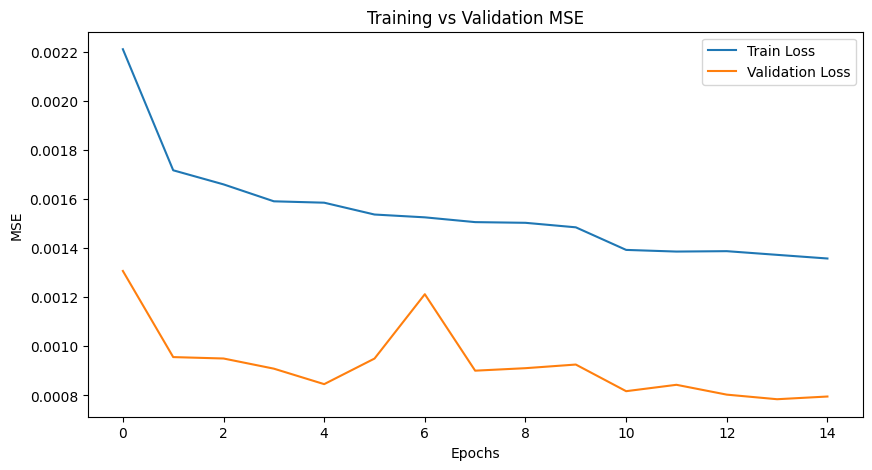

In [27]:
# plot training & validation MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training vs Validation MSE')
plt.legend()
plt.show()

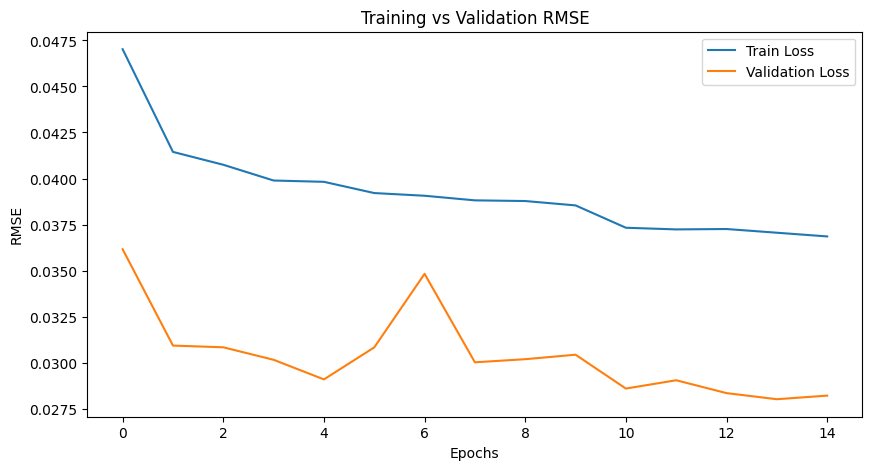

In [28]:
# plot training & validation RMSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['root_mean_squared_error'], label='Train Loss')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.show()

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, r2_score

# # Mendapatkan y_true dan y_pred dari generator validasi
# y_true = []
# y_pred = []

# for X_batch, y_batch in generatorValidate:  # Ambil batch dari generator validasi
#     predictions = model.predict(X_batch)  # Prediksi model

#     y_true.extend(y_batch)  # Simpan nilai aktual
#     y_pred.extend(predictions)  # Simpan hasil prediksi

# # Konversi ke array numpy
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

# # Konversi kembali ke skala asli menggunakan scaler.inverse_transform()
# y_true_rescaled = scaler.inverse_transform(y_true)
# y_pred_rescaled = scaler.inverse_transform(y_pred)

# # Hitung MSE dan R² Score
# mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
# r2 = r2_score(y_true_rescaled, y_pred_rescaled)

# # Print hasil evaluasi
# print(f"Validation MSE: {mse:.6f}")
# print(f"Validation R² : {r2:.6f}")

# # Plot hasil prediksi vs aktual
# plt.figure(figsize=(12, 6))
# plt.plot(val_index, y_true_rescaled[:, 0], label='Actual', color='blue')
# plt.plot(val_index, y_pred_rescaled[:, 0], label='Predicted', color='red', linestyle='dashed')
# plt.xlabel('Time')
# plt.ylabel('Polutan Value')
# plt.title('Actual vs Predicted')
# plt.legend()
# plt.show()

In [ ]:
# prediksi untuk data validasi
y_pred_val = model.predict(generatorValidate)

# prediksi untuk data training
y_pred_train = model.predict(generatorTrain)

# ambil nilai target sebenarnya dari dataset validasi
y_true_val = val_scaled[len(val_scaled) - len(y_pred_val):]  

# ambil nilai target sebenarnya dari dataset training
y_true_train = train_scaled[len(train_scaled) - len(y_pred_train):]  

# hitung MSE
mse_train = mean_squared_error(y_true_train, y_pred_train)
mse_val = mean_squared_error(y_true_val, y_pred_val)

# hitung R² Score
r2_train = r2_score(y_true_train, y_pred_train)
r2_val = r2_score(y_true_val, y_pred_val)

print(f"Training Set - MSE: {mse_train}, R² Score: {r2_train}")
print(f"Validation Set - MSE: {mse_val}, R² Score: {r2_val}")


3482/3482 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
28027/28027 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
Training Set - MSE: 0.0011188117445221615, R² Score: 0.902655383178674
Validation Set - MSE: 0.0007845074289581083, R² Score: 0.8141862808190483


### Forecasting

In [ ]:
# ambil 24 jam terakhir dari dataset validasi (input untuk prediksi)
last_24_hours = val_scaled[-24:].reshape(1, 24, val_scaled.shape[1])  # Sesuai shape model

# prediksi kadar polutan 1 jam ke depan
predicted_pollution = model.predict(last_24_hours)

# melakukan inverse transform
predicted_pollution = scaler.inverse_transform(predicted_pollution)

print(f"Prediksi kadar polutan 1 jam ke depan: {predicted_pollution}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Prediksi kadar polutan 1 jam ke depan: [[  94.618324   119.673485     3.7367332   92.30017   1514.8885
     9.106324 ]]


### Save Model

In [32]:
model.save('final_model.h5')

In [34]:
data_test_df = pd.DataFrame(test_data)
data_test_df.to_csv('data_train.csv')